### Imports and Setup

In [133]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow
!pip install matplotlib


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/tensorflow/docs to /private/var/folders/dd/7dd1dy955gvgf8vssnprd7nr0000gn/T/pip-req-build-gw2ctp9i
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/dd/7dd1dy955gvgf8vssnprd7nr0000gn/T/pip-req-build-gw2ctp9i
  Resolved https://github.com/tensorflow/docs to commit 6e395386ccc47dd44d769f15b6c99cce56b63fe6
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [134]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import requests
import tensorflow as tf
from tensorflow.python.lib.io import file_io
import shutil
import tensorflow as tf
from tensorflow.python.lib.io import file_io
import imageio
import io

## Datasets and Load

In [135]:
## Dataset URLs
house_url = 'gs://quickdraw_dataset/full/numpy_bitmap/house.npy'
aircraft_carrier_url = 'gs://quickdraw_dataset/full/numpy_bitmap/aircraft carrier.npy'
apple_url = 'gs://quickdraw_dataset/full/numpy_bitmap/apple.npy'
eiffel_tower_url = 'gs://quickdraw_dataset/full/numpy_bitmap/The Eiffel Tower.npy'
squirrel_url = 'gs://quickdraw_dataset/full/numpy_bitmap/squirrel.npy'


In [136]:
## Get the Function Data
def return_data_for_noun(URL):
    f = io.BytesIO(file_io.read_file_to_string(URL, binary_mode=True))
    data = np.load(f)
    data_reshaped = data.reshape(data.shape[0],28,28,1)
    data_reshaped = (data_reshaped - 127.5) / 127.5
    return data_reshaped

In [137]:
#Noun Datasets
#house_images = return_data_for_noun(house_url)
#aircraft_carrier_images = return_data_for_noun(aircraft_carrier_url)
apple_images = return_data_for_noun(apple_url)
#eiffel_tower_images = return_data_for_noun(eiffel_tower_url)
#squirrel_images = return_data_for_noun(squirrel_url)

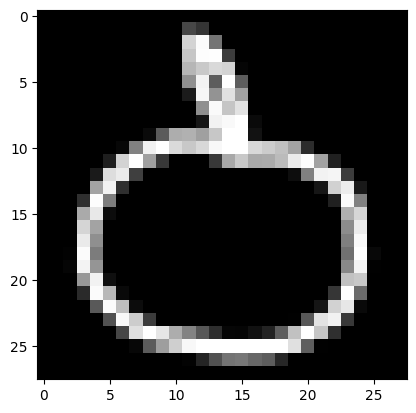

In [138]:
## TEST SHOW
plt.imshow(apple_images[42],cmap='gray')

## Training Setups

In [139]:
#Parameters
buffer_size = 1000
batch_size = 256
noun_focused = apple_images #Change this guys
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 1 #This has to be a perfect square



In [140]:
# Get the training data
def get_training_ready(noun_focused,buffer_size,batch_size):
    train_dataset = tf.data.Dataset.from_tensor_slices(noun_focused).shuffle(buffer_size).batch(batch_size)
    return train_dataset

In [141]:
# Get the training data
train_dataset = get_training_ready(noun_focused,buffer_size,batch_size)

## Create the models


In [142]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [143]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [144]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [145]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00040475]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers


In [146]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [147]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [148]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [149]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [150]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [151]:
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [156]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [161]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, num_examples_to_generate)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, num_examples_to_generate)

**Generate and save images**


In [158]:
def generate_and_save_images(model, epoch, test_input,num_examples_to_generate):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(int(num_examples_to_generate**0.5), int(num_examples_to_generate**0.5)))

  for i in range(predictions.shape[0]):
      plt.subplot(int(num_examples_to_generate**0.5), int(num_examples_to_generate**0.5), i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

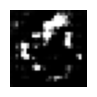

In [162]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [163]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [164]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

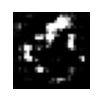

In [165]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [167]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/var/folders/dd/7dd1dy955gvgf8vssnprd7nr0000gn/T/ipykernel_71205/1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/dd/7dd1dy955gvgf8vssnprd7nr0000gn/T/ipykernel_71205/1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



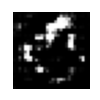

In [168]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)